In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)

In [4]:
from module.data.read_data import *

In [5]:
train = sales_file_processing()

In [6]:
test = test_file_processing().set_index('ID')

items = pd.read_csv(ITEMS_FILE)
shops = shops_file_processing()
cats = categories_file_processing()

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 3 columns):
shop_id           214200 non-null uint8
item_id           214200 non-null uint16
date_block_num    214200 non-null uint8
dtypes: uint16(1), uint8(2)
memory usage: 2.5 MB


## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

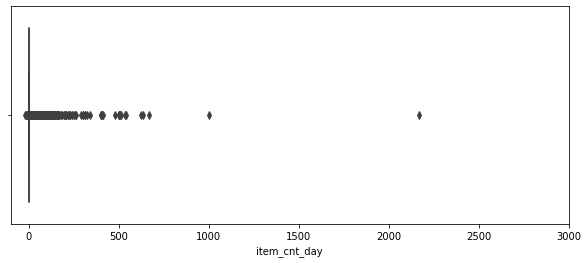

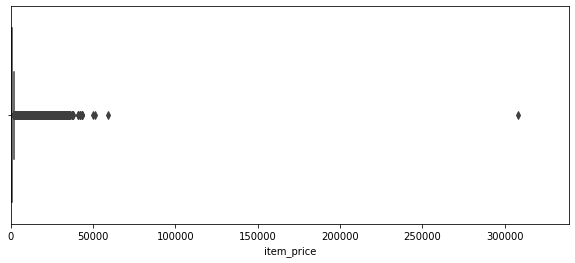

In [9]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [10]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with price below zero. Fill it with median.

In [11]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [11]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    _tmp = np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16')
    matrix.append(_tmp)
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

11.442414283752441

In [11]:
# date_block_nums = [i for i in range(35)]
# shop_ids = test['shop_id'].unique()
# item_ids = test['item_id'].unique()
# columns = ["date_block_num", "shop_id", "item_id"]

# index = pd.MultiIndex.from_product([date_block_nums, shop_ids, item_ids], names=columns)
# matrix = pd.DataFrame(index = index).reset_index()
# matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
# matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
# matrix['item_id'] = matrix['item_id'].astype(np.int16)
# matrix.sort_values(columns, inplace=True)
# matrix.fillna(0, inplace=True)

In [12]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10842077 entries, 114910 to 10698738
Data columns (total 3 columns):
date_block_num    int8
shop_id           int8
item_id           int16
dtypes: int16(1), int8(2)
memory usage: 124.1 MB


Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

<i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [13]:
ts = time.time()
cols = ['date_block_num','shop_id','item_id']
group = train.groupby(cols).agg({'item_cnt_day': ['sum'], 
                                 'item_price': ['first', 'last', 'min', 'mean', 'max']})

new_columns = ['item_cnt_month', 'item_price_open', 'item_price_close', 'item_price_min', 'item_price_mean', 'item_price_max']
group.columns = new_columns
group.reset_index(inplace=True)
group[new_columns] = group[new_columns].astype(np.float16)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16)

time.time() - ts

6.551445722579956

In [14]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10842077 entries, 0 to 10842076
Data columns (total 9 columns):
date_block_num      int8
shop_id             int8
item_id             int16
item_cnt_month      float16
item_price_open     float16
item_price_close    float16
item_price_min      float16
item_price_mean     float16
item_price_max      float16
dtypes: float16(6), int16(1), int8(2)
memory usage: 248.2 MB


## Test set
To use time tricks append test pairs to the matrix.

In [15]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [16]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.2902238368988037

In [17]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11056277 entries, 0 to 11056276
Data columns (total 9 columns):
date_block_num      int8
shop_id             int8
item_id             int16
item_cnt_month      float16
item_price_open     float16
item_price_close    float16
item_price_min      float16
item_price_mean     float16
item_price_max      float16
dtypes: float16(6), int16(1), int8(2)
memory usage: 168.7 MB


In [19]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_open,item_price_close,item_price_min,item_price_mean,item_price_max
0,0,2,19,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,27,1.0,2500.0,2500.0,2500.0,2500.0,2500.0
2,0,2,28,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,29,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,32,0.0,0.0,0.0,0.0,0.0,0.0


## Shops/Items/Cats features

In [20]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
time.time() - ts

4.965687036514282

In [21]:
matrix['item_category_id'] = matrix['item_category_id'].astype(np.uint8)
matrix.drop(['item_name'], axis=1, inplace=True)

In [22]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056277 entries, 0 to 11056276
Data columns (total 14 columns):
date_block_num       int8
shop_id              int8
item_id              int16
item_cnt_month       float16
item_price_open      float16
item_price_close     float16
item_price_min       float16
item_price_mean      float16
item_price_max       float16
city_id              uint8
item_category_id     uint8
category_id          uint8
subcategory_id       uint8
subsubcategory_id    uint8
dtypes: float16(6), int16(1), int8(2), uint8(5)
memory usage: 305.8 MB


## Traget lags

In [17]:
import pandas as pd


def __shift_and_append_column(df, grouped_columns, column, shift_size, drop=False):
    if 'date_block_num' not in grouped_columns:
        grouped_columns.insert(0, 'date_block_num')
    old_columns = grouped_columns.copy()
    old_columns.append(column)
    tmp = df[old_columns]
    result = df[old_columns]
    
    added_columns = []
    for _shift in shift_size:
        new_column_name = column + ' previous {}'.format(_shift)
        added_columns.append(new_column_name)
        new_columns = grouped_columns.copy()
        new_columns.append(new_column_name)
        
        shifted = tmp.copy()
        shifted.columns = new_columns
        shifted['date_block_num'] += _shift

        result = pd.merge(result, shifted, on=grouped_columns, how='left')
        
        del shifted

    df = df.join(result[added_columns])
    
    del result
    
    if drop:
        df.drop([column], axis=1, inplace=True)
    
    return df

In [24]:
grouped_columns = ['shop_id', 'item_id']
matrix = __shift_and_append_column(matrix, grouped_columns, 'item_cnt_month', [1, 2, 3])

In [25]:
matrix = __shift_and_append_column(matrix, grouped_columns, 'item_price_open', [1, 2, 3], drop=True)
matrix = __shift_and_append_column(matrix, grouped_columns, 'item_price_close', [1, 2, 3], drop=True)
matrix = __shift_and_append_column(matrix, grouped_columns, 'item_price_min', [1, 2, 3], drop=True)
matrix = __shift_and_append_column(matrix, grouped_columns, 'item_price_mean', [1, 2, 3], drop=True)
matrix = __shift_and_append_column(matrix, grouped_columns, 'item_price_max', [1, 2, 3], drop=True)

In [26]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056277 entries, 0 to 11056276
Data columns (total 27 columns):
date_block_num                 int8
shop_id                        int8
item_id                        int16
item_cnt_month                 float16
city_id                        uint8
item_category_id               uint8
category_id                    uint8
subcategory_id                 uint8
subsubcategory_id              uint8
item_cnt_month previous 1      float16
item_cnt_month previous 2      float16
item_cnt_month previous 3      float16
item_price_open previous 1     float16
item_price_open previous 2     float16
item_price_open previous 3     float16
item_price_close previous 1    float16
item_price_close previous 2    float16
item_price_close previous 3    float16
item_price_min previous 1      float16
item_price_min previous 2      float16
item_price_min previous 3      float16
item_price_mean previous 1     float16
item_price_mean previous 2     float16
item_p

## Mean encoded features

In [18]:
def __add_grouped_basics(df, columns, shift_size=None):
    _group_values = df.groupby(columns).agg({'item_cnt_month': ['min', 'mean', 'max']})

    column_base_name = '+'.join(columns)
    new_columns = [
        'item_cnt_month min per {}'.format(column_base_name),
        'item_cnt_month mean per {}'.format(column_base_name),
        'item_cnt_month max per {}'.format(column_base_name),
    ]

    _group_values.columns = new_columns
    _group_values.reset_index(inplace=True)
    
    df = pd.merge(df, _group_values, on=columns, how='left')
    del _group_values
    
    _shift_columns = ['shop_id', 'item_id']
    if shift_size is not None:
        df = __shift_and_append_column(df, _shift_columns, new_columns[0], shift_size, drop=True)
        df = __shift_and_append_column(df, _shift_columns, new_columns[1], shift_size, drop=True)
        df = __shift_and_append_column(df, _shift_columns, new_columns[2], shift_size, drop=True)

    return df

In [28]:
shifts = [1, 2, 3]

In [29]:
ts = time.time()
matrix = __add_grouped_basics(matrix, ['date_block_num', 'item_id'], shifts)
matrix = __add_grouped_basics(matrix, ['date_block_num', 'shop_id'], shifts)
matrix = __add_grouped_basics(matrix, ['date_block_num', 'city_id'], shifts)
matrix = __add_grouped_basics(matrix, ['date_block_num', 'category_id'], shifts)
time.time() - ts

291.7171037197113

In [30]:
ts = time.time()
matrix = __add_grouped_basics(matrix, ['date_block_num', 'shop_id', 'category_id'], shifts)
matrix = __add_grouped_basics(matrix, ['date_block_num', 'shop_id', 'category_id', 'subcategory_id'], shifts)
matrix = __add_grouped_basics(matrix, ['date_block_num', 'shop_id', 'city_id'], shifts)
time.time() - ts

247.36629843711853

In [31]:
ts = time.time()
matrix = __add_grouped_basics(matrix, ['date_block_num', 'category_id', 'city_id'], shifts)
matrix = __add_grouped_basics(matrix, ['date_block_num', 'category_id', 'item_id'], shifts)
matrix = __add_grouped_basics(matrix, ['date_block_num', 'category_id', 'subcategory_id'], shifts)
matrix = __add_grouped_basics(matrix, ['date_block_num', 'category_id', 'subcategory_id', 'city_id'], shifts)
time.time() - ts

402.47475361824036

In [32]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056277 entries, 0 to 11056276
Columns: 126 entries, date_block_num to item_cnt_month max per date_block_num+category_id+subcategory_id+city_id previous 3
dtypes: float16(118), int16(1), int8(2), uint8(5)
memory usage: 2.9 GB


In [34]:
ts = time.time()
matrix = __add_grouped_basics(matrix, ['date_block_num'], shifts)
matrix = __add_grouped_basics(matrix, ['date_block_num', 'shop_id', 'subcategory_id'], shifts)

time.time() - ts

214.96916365623474

In [35]:
ts = time.time()
matrix = __add_grouped_basics(matrix, ['date_block_num', 'shop_id', 'subsubcategory_id'], shifts)
matrix = __add_grouped_basics(matrix, ['date_block_num', 'item_id', 'city_id'], shifts)

time.time() - ts

248.14375948905945

In [36]:
ts = time.time()
matrix = __add_grouped_basics(matrix, ['date_block_num', 'subcategory_id'], shifts)
matrix = __add_grouped_basics(matrix, ['date_block_num', 'subsubcategory_id'], shifts)

time.time() - ts

264.661105632782

In [37]:
matrix.to_pickle('data_4.pkl')

## Trend features

Price trend for the last six months.

In [1]:
del matrix

NameError: name 'matrix' is not defined

In [12]:
matrix = pd.read_pickle('data_4.pkl')

In [13]:
ts = time.time()
grouped_columns = ['date_block_num','item_id']
methods = ['first', 'last', 'min', 'mean', 'max']
group = train.groupby(grouped_columns).agg({'item_price': methods})

new_columns = ['item_{}_item_price'.format(method) for method in methods]
group.columns = new_columns
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=grouped_columns, how='left')
matrix[new_columns] = matrix[new_columns].astype(np.float16)

time.time() - ts

33.56819438934326

In [14]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056277 entries, 0 to 11056276
Columns: 185 entries, date_block_num to item_max_item_price
dtypes: float16(177), int16(1), int8(2), uint8(5)
memory usage: 3.8 GB


In [15]:
del test
del items
del cats
del shops

In [43]:
_columns = [column for column in matrix.columns if ('min' not in column) and ('max' not in column)]
matrix = matrix[_columns]

In [19]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056277 entries, 0 to 11056276
Columns: 185 entries, date_block_num to item_max_item_price
dtypes: float16(177), int16(1), int8(2), uint8(5)
memory usage: 3.8 GB


In [20]:
grouped_columns = ['date_block_num', 'shop_id', 'item_id']
shifts = [1, 2, 3]
for column in new_columns:
    if column in matrix.columns:
        matrix = __shift_and_append_column(matrix, grouped_columns, column, [1, 2, 3], drop=True)
        matrix['delta_{} previous {}'.format(column, 1)] = (matrix['{} previous {}'.format(column, 1)] - matrix['{} previous {}'.format(column, 2)]) / matrix['{} previous {}'.format(column, 2)]
        matrix['delta_{} previous {}'.format(column, 2)] = matrix['{} previous {}'.format(column, 2)] - matrix['{} previous {}'.format(column, 3)] / matrix['{} previous {}'.format(column, 3)]
    
matrix.fillna(0, inplace=True)

time.time() - ts

1617.1448323726654

Last month shop revenue trend

In [21]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']


ts = time.time()
grouped_columns = ['date_block_num', 'shop_id']
methods = ['sum']
group = train.groupby(grouped_columns).agg({'revenue': methods})

new_columns = ['date_shop_revenue_{}'.format(method) for method in methods]
group.columns = new_columns
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=grouped_columns, how='left')
matrix[new_columns] = matrix[new_columns].astype(np.float16)

time.time() - ts

32.89003801345825

In [22]:
grouped_columns = ['date_block_num', 'shop_id', 'item_id']
shifts = [1, 2, 3]
for column in new_columns:
    if column in matrix.columns:
        matrix = __shift_and_append_column(matrix, grouped_columns, column, [1, 2, 3], drop=True)
        matrix['delta_{} previous {}'.format(column, 1)] = (matrix['{} previous {}'.format(column, 1)] - matrix['{} previous {}'.format(column, 2)]) / matrix['{} previous {}'.format(column, 2)]
        matrix['delta_{} previous {}'.format(column, 2)] = matrix['{} previous {}'.format(column, 2)] - matrix['{} previous {}'.format(column, 3)] / matrix['{} previous {}'.format(column, 3)]
    
matrix.fillna(0, inplace=True)

time.time() - ts

92.0269935131073

In [23]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056277 entries, 0 to 11056276
Columns: 210 entries, date_block_num to delta_date_shop_revenue_sum previous 2
dtypes: float16(202), int16(1), int8(2), uint8(5)
memory usage: 4.6 GB


In [24]:
matrix.to_pickle('data_41.pkl')

## Special features

In [25]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [26]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [27]:
seasons = pd.Series([0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0])
matrix['season'] = matrix['month'].map(seasons).astype(np.int8)

In [28]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056277 entries, 0 to 11056276
Columns: 213 entries, date_block_num to season
dtypes: float16(202), int16(1), int8(5), uint8(5)
memory usage: 4.7 GB


In [29]:
matrix.to_pickle('data_4full.pkl')

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [30]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

917.5164849758148

In [31]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

630.8715617656708

Months since the first sale for each shop/item pair and for item only.

In [32]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

2.285884141921997

In [33]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056277 entries, 0 to 11056276
Columns: 217 entries, date_block_num to item_first_sale
dtypes: float16(202), int16(1), int8(9), uint8(5)
memory usage: 4.7 GB


## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

Producing lags brings a lot of nulls.

In [34]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

4.30059552192688

In [67]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_id',
       'item_category_id', 'category_id', 'subcategory_id',
       'subsubcategory_id', 'item_cnt_month previous 1',
       'item_cnt_month previous 2', 'item_cnt_month previous 3',
       'item_price_open previous 1', 'item_price_open previous 2',
       'item_price_open previous 3', 'item_price_close previous 1',
       'item_price_close previous 2', 'item_price_close previous 3',
       'item_price_mean previous 1', 'item_price_mean previous 2',
       'item_price_mean previous 3',
       'item_cnt_month mean per date_block_num+item_id previous 1',
       'item_cnt_month mean per date_block_num+item_id previous 2',
       'item_cnt_month mean per date_block_num+item_id previous 3',
       'item_cnt_month mean per date_block_num+shop_id previous 1',
       'item_cnt_month mean per date_block_num+shop_id previous 2',
       'item_cnt_month mean per date_block_num+shop_id previous 3',
       'item_cnt_month mea

In [68]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7497000 entries, 0 to 7496999
Data columns (total 95 columns):
date_block_num                                                                          int8
shop_id                                                                                 int8
item_id                                                                                 int16
item_cnt_month                                                                          float16
city_id                                                                                 uint8
item_category_id                                                                        uint8
category_id                                                                             uint8
subcategory_id                                                                          uint8
subsubcategory_id                                                                       uint8
item_cnt_month previous 1                

In [35]:
matrix.to_pickle('data_full.pkl')
del matrix
# del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

NameError: name 'items' is not defined